#### Import Data

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [5]:
train = pd.read_csv("https://datahack-prod.s3.amazonaws.com/train_file/train_v9rqX0R.csv")
test = pd.read_csv("https://datahack-prod.s3.amazonaws.com/test_file/test_AbJTz2l.csv")
sample = pd.read_csv("https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_8RXa3c6.csv")

## Preprocessing

In [6]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
test.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
5676,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5679,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1
5680,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [8]:
train.columns.difference(test.columns)

Index(['Item_Outlet_Sales'], dtype='object')

In [9]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [10]:
5681/8523

0.6665493370878799

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [12]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [13]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [14]:
test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [15]:
train.Item_Identifier[:10]

0    FDA15
1    DRC01
2    FDN15
3    FDX07
4    NCD19
5    FDP36
6    FDO10
7    FDP10
8    FDH17
9    FDU28
Name: Item_Identifier, dtype: object

In [16]:
train['source'] = 'train'
test['source'] = 'test'

In [17]:
train[:5]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [18]:
df = pd.concat([train, test])
df[:3]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train


In [19]:
df.shape

(14204, 13)

In [20]:
df['Item_Identifier'].nunique()

1559

In [21]:
df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [22]:
df['Item_Identifier_2'] = df['Item_Identifier'].apply(lambda x : x[0:2])
df['Item_Identifier_3'] = df['Item_Identifier'].apply(lambda x : x[0:3])

In [23]:
df['Item_Identifier_2'].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Identifier_2, dtype: int64

In [24]:
df['Item_Identifier_3'].value_counts()[:5]

FDT    467
FDW    460
FDX    460
FDV    454
FDU    452
Name: Item_Identifier_3, dtype: int64

In [25]:
del df['Item_Identifier_3']

In [26]:
df.shape

(14204, 14)

In [27]:
df['Item_Weight'].isna().sum()

2439

In [28]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,NC


In [29]:
df.groupby(["Item_Identifier_2"])['Item_Weight'].mean()

Item_Identifier_2
DR    12.116645
FD    12.735577
NC    13.344139
Name: Item_Weight, dtype: float64

In [30]:
# df.groupby('Item_Identifier_2').Item_Weight.transform(lambda x: x.fillna(x.mean()))

In [31]:
df['Item_Weight'] = df.groupby('Item_Identifier_2').Item_Weight.transform(lambda x: x.fillna(x.mean()))

In [32]:
df['Item_Weight'].isna().sum()

0

In [33]:
df['Item_Fat_Content'].nunique()

5

In [34]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [35]:
df['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [36]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({"LF": "Low Fat", "reg": "Regular", "low fat": "Low Fat"})

In [37]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

<AxesSubplot:ylabel='Frequency'>

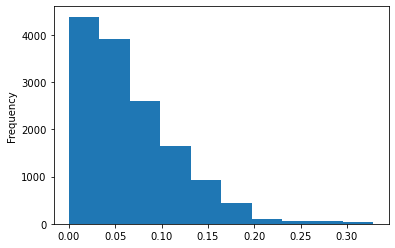

In [38]:
df['Item_Visibility'].plot(kind = 'hist')

In [39]:
df['Item_Visibility'].value_counts(ascending = False)

0.000000    879
0.076792      3
0.077169      3
0.076841      3
0.076975      3
           ... 
0.044503      1
0.030933      1
0.059281      1
0.019228      1
0.031007      1
Name: Item_Visibility, Length: 13006, dtype: int64

In [40]:
df.sort_values(by = ['Item_Identifier', 'Item_Visibility'])

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2
1197,DRA12,11.600000,Low Fat,0.000000,Soft Drinks,141.6154,OUT045,2002,NaN,Tier 2,Supermarket Type1,3829.0158,train,DR
1693,DRA12,11.600000,Low Fat,0.000000,Soft Drinks,141.9154,OUT035,2004,Small,Tier 2,Supermarket Type1,992.7078,train,DR
3912,DRA12,12.116645,Low Fat,0.040748,Soft Drinks,140.0154,OUT027,1985,Medium,Tier 3,Supermarket Type3,NaN,test,DR
1245,DRA12,11.600000,Low Fat,0.040912,Soft Drinks,142.3154,OUT013,1987,High,Tier 3,Supermarket Type1,2552.6772,train,DR
500,DRA12,11.600000,Low Fat,0.040946,Soft Drinks,142.9154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,test,DR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7926,NCZ54,14.650000,Low Fat,0.083489,Household,161.3552,OUT049,1999,Medium,Tier 1,Supermarket Type1,7148.0288,train,NC
1969,NCZ54,14.650000,Low Fat,0.083528,Household,162.4552,OUT045,2002,NaN,Tier 2,Supermarket Type1,2274.3728,train,NC
7738,NCZ54,14.650000,Low Fat,0.083699,Household,163.4552,OUT018,2009,Medium,Tier 3,Supermarket Type2,2599.2832,train,NC
4700,NCZ54,14.650000,Low Fat,0.083831,Household,161.4552,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,test,NC


In [41]:
df.loc[df['Item_Visibility'] == 0.000000, 'Item_Visibility'] = np.NAN

In [42]:
df['Item_Visibility'].isna().sum()

879

In [43]:
df['Item_Visibility'] = df.groupby('Item_Identifier_2').Item_Visibility.transform(lambda x: x.fillna(x.mean()))

<AxesSubplot:ylabel='Frequency'>

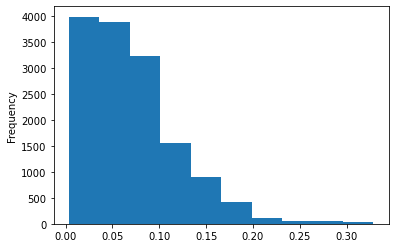

In [44]:
df['Item_Visibility'].plot(kind = 'hist')

In [45]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,FD
3,FDX07,19.20,Regular,0.072558,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train,FD
4,NCD19,8.93,Low Fat,0.062099,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,NC


In [46]:
df['Item_Type'].value_counts()

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

In [47]:
df['Outlet_Identifier'].isna().sum()

0

<AxesSubplot:ylabel='Frequency'>

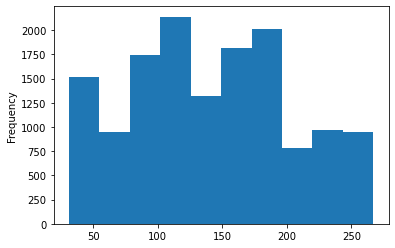

In [48]:
df['Item_MRP'].plot(kind = 'hist')

In [49]:
df['Outlet_Identifier'].value_counts()

OUT027    1559
OUT013    1553
OUT046    1550
OUT035    1550
OUT049    1550
OUT045    1548
OUT018    1546
OUT017    1543
OUT010     925
OUT019     880
Name: Outlet_Identifier, dtype: int64

In [50]:
df['Outlet_Establishment_Year'].value_counts()

1985    2439
1987    1553
2004    1550
1997    1550
1999    1550
2002    1548
2009    1546
2007    1543
1998     925
Name: Outlet_Establishment_Year, dtype: int64

In [51]:
df['Outlet_Establishment_Year'].nunique()

9

In [52]:
df.groupby('Outlet_Establishment_Year')['Outlet_Identifier'].value_counts()

Outlet_Establishment_Year  Outlet_Identifier
1985                       OUT027               1559
                           OUT019                880
1987                       OUT013               1553
1997                       OUT046               1550
1998                       OUT010                925
1999                       OUT049               1550
2002                       OUT045               1548
2004                       OUT035               1550
2007                       OUT017               1543
2009                       OUT018               1546
Name: Outlet_Identifier, dtype: int64

In [53]:
datetime.now().year, datetime.now().month

(2021, 4)

In [54]:
df['Outlet_Age'] = datetime.now().year - df['Outlet_Establishment_Year']

In [55]:
df['Outlet_Age'].value_counts()

36    2439
34    1553
24    1550
17    1550
22    1550
19    1548
12    1546
14    1543
23     925
Name: Outlet_Age, dtype: int64

In [56]:
del df['Outlet_Establishment_Year']

In [57]:
df['Outlet_Size'].value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [58]:
df['Outlet_Size'].isna().sum()

4016

In [59]:
df.groupby('Outlet_Identifier')['Outlet_Size'].value_counts()

Outlet_Identifier  Outlet_Size
OUT013             High           1553
OUT018             Medium         1546
OUT019             Small           880
OUT027             Medium         1559
OUT035             Small          1550
OUT046             Small          1550
OUT049             Medium         1550
Name: Outlet_Size, dtype: int64

In [60]:
df['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [61]:
df.groupby('Outlet_Location_Type')['Outlet_Size'].value_counts()

Outlet_Location_Type  Outlet_Size
Tier 1                Small          2430
                      Medium         1550
Tier 2                Small          1550
Tier 3                Medium         3105
                      High           1553
Name: Outlet_Size, dtype: int64

In [62]:
df.groupby(['Outlet_Location_Type', 'Outlet_Type']).Outlet_Size.value_counts()

Outlet_Location_Type  Outlet_Type        Outlet_Size
Tier 1                Grocery Store      Small           880
                      Supermarket Type1  Medium         1550
                                         Small          1550
Tier 2                Supermarket Type1  Small          1550
Tier 3                Supermarket Type1  High           1553
                      Supermarket Type2  Medium         1546
                      Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [63]:
df.groupby(['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Size']).Item_Weight.value_counts()

Outlet_Location_Type  Outlet_Type        Outlet_Size  Item_Weight
Tier 1                Grocery Store      Small        12.735577       637
                                                      13.344139       168
                                                      12.116645        75
                      Supermarket Type1  Medium       17.600000        18
                                                      12.150000        17
                                                                     ... 
Tier 3                Supermarket Type2  Medium       9.420000          1
                                                      21.000000         1
                      Supermarket Type3  Medium       12.735577      1119
                                                      13.344139       295
                                                      12.116645       145
Name: Item_Weight, Length: 2076, dtype: int64

In [64]:
df.groupby(['Outlet_Type']).Outlet_Size.value_counts()

Outlet_Type        Outlet_Size
Grocery Store      Small           880
Supermarket Type1  Small          3100
                   High           1553
                   Medium         1550
Supermarket Type2  Medium         1546
Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [65]:
df[:3]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,train,FD,22
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,train,DR,12
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,train,FD,22


In [66]:
df['Outlet_Size'].mode()[0]

'Medium'

In [67]:
# df.groupby('Outlet_Location_Type').Outlet_Size.transform(lambda x: x.fillna(x.mode()[0]))

In [68]:
df['Outlet_Size'] = df.groupby('Outlet_Location_Type').Outlet_Size.transform(lambda x: x.fillna(x.mode()[0]))

In [69]:
df['Outlet_Size'].isna().sum()

0

In [70]:
df['Outlet_Type'].value_counts()

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [71]:
df['Outlet_Type'].apply(lambda x: x.split()[0])[:5]

0    Supermarket
1    Supermarket
2    Supermarket
3        Grocery
4    Supermarket
Name: Outlet_Type, dtype: object

In [72]:
df['Outlet_Type_Category'] =  df['Outlet_Type'].apply(lambda x: x.split()[0])

In [73]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2,Outlet_Age,Outlet_Type_Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,train,FD,22,Supermarket
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,train,DR,12,Supermarket
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,train,FD,22,Supermarket
3,FDX07,19.20,Regular,0.072558,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,train,FD,23,Grocery
4,NCD19,8.93,Low Fat,0.062099,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,train,NC,34,Supermarket


In [74]:
df['Outlet_Type_Category'].value_counts()

Supermarket    12399
Grocery         1805
Name: Outlet_Type_Category, dtype: int64

In [75]:
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age
Item_Weight,1.000000,-0.016502,0.033206,0.011182,-0.000312
Item_Visibility,-0.016502,1.000000,-0.008853,-0.133754,0.088624
Item_MRP,0.033206,-0.008853,1.000000,0.567574,-0.000141
Item_Outlet_Sales,0.011182,-0.133754,0.567574,1.000000,0.049135
Outlet_Age,-0.000312,0.088624,-0.000141,0.049135,1.000000


In [76]:
X = df.select_dtypes(include=np.number).drop(columns=['Item_Outlet_Sales'])

In [77]:
X[:4]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age
0,9.30,0.016047,249.8092,22
1,5.92,0.019278,48.2692,12
2,17.50,0.016760,141.6180,22
3,19.20,0.072558,182.0950,23


In [78]:
X.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age'], dtype='object')

In [79]:
vif_data = pd.DataFrame()


In [80]:
vif_data

""


In [81]:
vif_data['Feature'] = X.columns

In [82]:
vif_data

,Feature
0,Item_Weight
1,Item_Visibility
2,Item_MRP
3,Outlet_Age


In [83]:
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [84]:
list(range(len(X.columns)))

[0, 1, 2, 3]

In [85]:
vif_data

,Feature,VIF
0,Item_Weight,6.436093
1,Item_Visibility,2.908423
2,Item_MRP,4.947795
3,Outlet_Age,6.197776


In [86]:
df_number_columns = df.select_dtypes(include=np.number).columns

In [87]:
df_number_columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales',
       'Outlet_Age'],
      dtype='object')

In [88]:
df_category_columns = df.select_dtypes(exclude=np.number).columns

In [89]:
df_category_columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'source',
       'Item_Identifier_2', 'Outlet_Type_Category'],
      dtype='object')

In [90]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_Identifier_2,Outlet_Age,Outlet_Type_Category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,train,FD,22,Supermarket
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,train,DR,12,Supermarket
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,train,FD,22,Supermarket
3,FDX07,19.20,Regular,0.072558,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,train,FD,23,Grocery
4,NCD19,8.93,Low Fat,0.062099,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,train,NC,34,Supermarket


In [91]:
data_to_encode = df[df_category_columns].drop(columns = ['Item_Identifier', 'Outlet_Identifier', 'source'] )

In [92]:
data_to_encode[:3]

,Item_Fat_Content,Item_Type,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_2,Outlet_Type_Category
0,Low Fat,Dairy,Medium,Tier 1,Supermarket Type1,FD,Supermarket
1,Regular,Soft Drinks,Medium,Tier 3,Supermarket Type2,DR,Supermarket
2,Low Fat,Meat,Medium,Tier 1,Supermarket Type1,FD,Supermarket


In [93]:
df_category_encoded =  pd.get_dummies(data_to_encode)

In [94]:
df_category_encoded[:2]

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_2_DR,Item_Identifier_2_FD,Item_Identifier_2_NC,Outlet_Type_Category_Grocery,Outlet_Type_Category_Supermarket
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1


In [95]:
df_final = pd.concat([df_category_encoded, df[df_number_columns], 
                      df[['Item_Identifier', 'Outlet_Identifier', 'source']]], axis = 1)

In [96]:
df_final.head()

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Type_Category_Grocery,Outlet_Type_Category_Supermarket,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Identifier,Outlet_Identifier,source
0,1,0,0,0,0,0,1,0,0,0,...,0,1,9.30,0.016047,249.8092,3735.1380,22,FDA15,OUT049,train
1,0,1,0,0,0,0,0,0,0,0,...,0,1,5.92,0.019278,48.2692,443.4228,12,DRC01,OUT018,train
2,1,0,0,0,0,0,0,0,0,0,...,0,1,17.50,0.016760,141.6180,2097.2700,22,FDN15,OUT049,train
3,0,1,0,0,0,0,0,0,1,0,...,1,0,19.20,0.072558,182.0950,732.3800,23,FDX07,OUT010,train
4,1,0,0,0,0,0,0,0,0,0,...,0,1,8.93,0.062099,53.8614,994.7052,34,NCD19,OUT013,train


In [97]:
train_preprocessed = df_final[df_final['source'] == 'train']
test_preprocessed = df_final[df_final['source'] == 'test']

In [98]:
train_preprocessed.shape, test_preprocessed.shape

((8523, 41), (5681, 41))

In [99]:
del train_preprocessed['source']
train_preprocessed.head()

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Item_Identifier_2_NC,Outlet_Type_Category_Grocery,Outlet_Type_Category_Supermarket,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Identifier,Outlet_Identifier
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,9.30,0.016047,249.8092,3735.1380,22,FDA15,OUT049
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,5.92,0.019278,48.2692,443.4228,12,DRC01,OUT018
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,17.50,0.016760,141.6180,2097.2700,22,FDN15,OUT049
3,0,1,0,0,0,0,0,0,1,0,...,0,1,0,19.20,0.072558,182.0950,732.3800,23,FDX07,OUT010
4,1,0,0,0,0,0,0,0,0,0,...,1,0,1,8.93,0.062099,53.8614,994.7052,34,NCD19,OUT013


In [100]:
del test_preprocessed['source']
test_preprocessed.head()

,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Item_Identifier_2_NC,Outlet_Type_Category_Grocery,Outlet_Type_Category_Supermarket,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Identifier,Outlet_Identifier
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,20.750000,0.007565,107.8622,NaN,22,FDW58,OUT049
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,8.300000,0.038428,87.3198,NaN,14,FDW14,OUT017
2,1,0,0,0,0,0,0,0,0,0,...,1,1,0,14.600000,0.099575,241.7538,NaN,23,NCN55,OUT010
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,7.315000,0.015388,155.0340,NaN,14,FDQ58,OUT017
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,12.735577,0.118599,234.2300,NaN,36,FDY38,OUT027


In [101]:
train_X = train_preprocessed.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])

In [102]:
test_X = test_preprocessed.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])

In [103]:
train_y = train_preprocessed['Item_Outlet_Sales']

In [104]:
train_y[:5]

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [105]:
sample = pd.read_csv("https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_8RXa3c6.csv")

In [106]:
sample.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1000
1,FDW14,OUT017,1000
2,NCN55,OUT010,1000
3,FDQ58,OUT017,1000
4,FDY38,OUT027,1000


## Modeling

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [108]:
lm = LinearRegression()
lm.fit(train_X, train_y)
pred_train = lm.predict(train_X)
pred_test = lm.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  835.9428028725182
RMSE:  1127.7422182890919
R-squared:  0.5632245226668964


In [106]:
sample['Item_Outlet_Sales'] = pred_test

## Regularization

In [110]:
# sample.to_csv('BigMart_LinearRegressionOutput.csv')

In [111]:
from sklearn.model_selection import cross_val_score

In [125]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [121]:
def run_model(model, train_X, train_y, test_X, sample, filename):
    model.fit(train_X, train_y)
    pd.Series(model.coef_, index =test_X.columns).plot(kind = 'bar')
    pred_train = model.predict(train_X)
    pred_test = model.predict(test_X)
    pred_test = abs(pred_test)
    print('MAE: ', mean_absolute_error(train_y, pred_train))
    cv_score = cross_val_score(model, train_X, train_y, cv = 10, scoring = 'neg_mean_absolute_error')
    print('CV score: ', np.mean(np.abs(cv_score)))
    print('R-squared: ', r2_score(train_y, pred_train))
    sample['Item_Outlet_Sales'] = pred_test
#     sample.to_csv(filename, index = False)
    sample.head()

MAE:  835.9428028725182
CV score:  839.7594122998368
R-squared:  0.5632245226668964


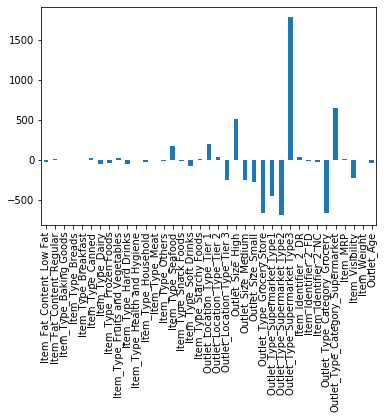

In [122]:
model = LinearRegression()
run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

In [135]:
# model = Lasso(alpha = 0) #Just as Linear Regression
# run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

MAE:  840.1643704299814
CV score:  840.7615821939432
R-squared:  0.5534691409208817


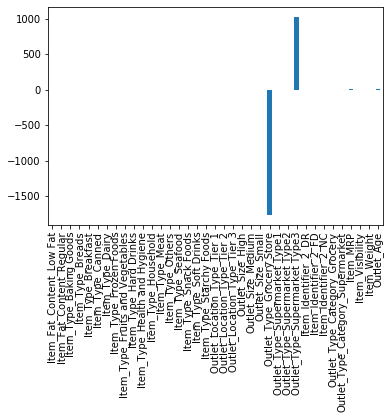

In [129]:
model = Lasso(alpha = 30)
run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

In [139]:
# model = Lasso(alpha = .005)
# run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

MAE:  836.05874362892
CV score:  839.4994606977983
R-squared:  0.5623286269423307


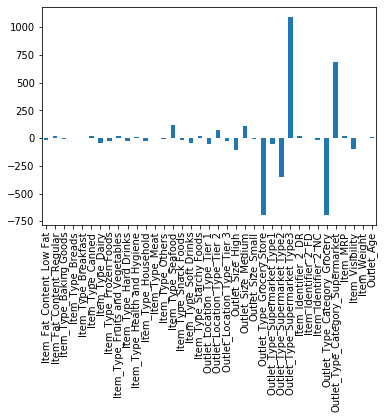

In [130]:
model = Ridge(alpha = 30)
run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

MAE:  909.254053000834
CV score:  910.2530708759972
R-squared:  0.4693808243180325


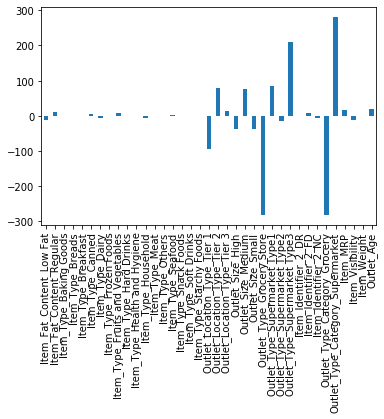

In [133]:
model = ElasticNet(alpha = 1, l1_ratio=0.5)
run_model(model, train_X, train_y, test_X, sample, 'test_result_LR.csv')

#### Desicion Tree

In [112]:
dtree = DecisionTreeRegressor()

In [113]:
dtree.fit(train_X, train_y)
pred_train = dtree.predict(train_X)
pred_test = dtree.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  0.0
RMSE:  0.0
R-squared:  1.0


In [116]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('Dtree_bigmart.csv', index = False)

#### Bagging 

In [117]:
bag = BaggingRegressor()

In [118]:
bag.fit(train_X, train_y)
pred_train = bag.predict(train_X)
pred_test = bag.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  320.97463379795846
RMSE:  489.87662366472966
R-squared:  0.9175839111384936


In [119]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('Baging_bigmart.csv', index = False)

#### Random Forest

In [120]:
rf = RandomForestRegressor()

In [121]:
rf.fit(train_X, train_y)
pred_train = rf.predict(train_X)
pred_test = rf.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  295.54742791880784
RMSE:  426.9964870434353
R-squared:  0.9373837329506488


In [122]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('Rf_bigmart.csv', index = False)

#### Ada boost

In [123]:
ada = AdaBoostRegressor()

In [124]:
ada.fit(train_X, train_y)
pred_train = ada.predict(train_X)
pred_test = ada.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  894.5941063402787
RMSE:  1162.0473834661116
R-squared:  0.5362475220076605


In [125]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('ADa_bigmart.csv', index = False)

#### Gradient Boost

In [127]:
grad = GradientBoostingRegressor()

In [128]:
grad.fit(train_X, train_y)
pred_train = grad.predict(train_X)
pred_test = grad.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  730.5002362787618
RMSE:  1037.5214299989648
R-squared:  0.630314241387153


In [129]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('Grad_bigmart.csv', index = False)

#### XGB

In [130]:
xgb = XGBRegressor()

In [131]:
xgb.fit(train_X, train_y)
pred_train = xgb.predict(train_X)
pred_test = xgb.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  512.1188348054312
RMSE:  711.6675520029904
R-squared:  0.8260626301272597


In [132]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('XGB_bigmart.csv', index = False)

#### CAT

In [133]:
cat = CatBoostRegressor()

In [134]:
cat.fit(train_X, train_y)
pred_train = cat.predict(train_X)
pred_test = cat.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

Learning rate set to 0.057154
0:	learn: 1655.3965037	total: 71.3ms	remaining: 1m 11s
1:	learn: 1604.4884892	total: 75.1ms	remaining: 37.5s
2:	learn: 1559.5055121	total: 78.8ms	remaining: 26.2s
3:	learn: 1516.0654820	total: 82.2ms	remaining: 20.5s
4:	learn: 1478.1735846	total: 85.8ms	remaining: 17.1s
5:	learn: 1442.3672427	total: 89.5ms	remaining: 14.8s
6:	learn: 1408.6261611	total: 92.9ms	remaining: 13.2s
7:	learn: 1377.8285173	total: 96.6ms	remaining: 12s
8:	learn: 1350.9107728	total: 101ms	remaining: 11.2s
9:	learn: 1324.6486420	total: 105ms	remaining: 10.4s
10:	learn: 1301.2014088	total: 109ms	remaining: 9.78s
11:	learn: 1280.6018661	total: 113ms	remaining: 9.27s
12:	learn: 1261.3076744	total: 116ms	remaining: 8.81s
13:	learn: 1244.1102321	total: 120ms	remaining: 8.43s
14:	learn: 1228.1511928	total: 123ms	remaining: 8.08s
15:	learn: 1213.4049524	total: 127ms	remaining: 7.78s
16:	learn: 1200.0588591	total: 130ms	remaining: 7.52s
17:	learn: 1188.7961975	total: 134ms	remaining: 7.31s
1

185:	learn: 1027.5127476	total: 736ms	remaining: 3.22s
186:	learn: 1027.2006848	total: 740ms	remaining: 3.22s
187:	learn: 1026.7716896	total: 744ms	remaining: 3.21s
188:	learn: 1026.5172162	total: 747ms	remaining: 3.21s
189:	learn: 1026.1772658	total: 751ms	remaining: 3.2s
190:	learn: 1025.8030435	total: 754ms	remaining: 3.19s
191:	learn: 1025.3589963	total: 760ms	remaining: 3.2s
192:	learn: 1024.9609677	total: 766ms	remaining: 3.2s
193:	learn: 1024.7123381	total: 770ms	remaining: 3.2s
194:	learn: 1024.4064276	total: 775ms	remaining: 3.2s
195:	learn: 1024.0899706	total: 779ms	remaining: 3.19s
196:	learn: 1023.6958314	total: 782ms	remaining: 3.19s
197:	learn: 1023.2788045	total: 786ms	remaining: 3.18s
198:	learn: 1023.0711994	total: 789ms	remaining: 3.18s
199:	learn: 1022.6512578	total: 793ms	remaining: 3.17s
200:	learn: 1022.2889903	total: 796ms	remaining: 3.17s
201:	learn: 1022.1633823	total: 800ms	remaining: 3.16s
202:	learn: 1021.9559461	total: 804ms	remaining: 3.15s
203:	learn: 102

348:	learn: 982.4870717	total: 1.49s	remaining: 2.78s
349:	learn: 982.3007112	total: 1.5s	remaining: 2.78s
350:	learn: 981.9900846	total: 1.5s	remaining: 2.78s
351:	learn: 981.7669338	total: 1.51s	remaining: 2.77s
352:	learn: 981.5735290	total: 1.51s	remaining: 2.77s
353:	learn: 981.4044623	total: 1.51s	remaining: 2.76s
354:	learn: 981.2597816	total: 1.52s	remaining: 2.76s
355:	learn: 981.0772425	total: 1.52s	remaining: 2.75s
356:	learn: 980.7713705	total: 1.52s	remaining: 2.75s
357:	learn: 980.6037074	total: 1.53s	remaining: 2.74s
358:	learn: 980.3106079	total: 1.53s	remaining: 2.73s
359:	learn: 980.1298346	total: 1.53s	remaining: 2.73s
360:	learn: 979.7665037	total: 1.54s	remaining: 2.73s
361:	learn: 979.6550462	total: 1.55s	remaining: 2.73s
362:	learn: 979.3923614	total: 1.55s	remaining: 2.73s
363:	learn: 978.9984692	total: 1.56s	remaining: 2.72s
364:	learn: 978.7764951	total: 1.56s	remaining: 2.72s
365:	learn: 978.4813021	total: 1.57s	remaining: 2.72s
366:	learn: 978.0474935	total:

523:	learn: 944.1276289	total: 2.21s	remaining: 2.01s
524:	learn: 943.9203201	total: 2.22s	remaining: 2.01s
525:	learn: 943.7720386	total: 2.22s	remaining: 2s
526:	learn: 943.6288818	total: 2.23s	remaining: 2s
527:	learn: 943.4521319	total: 2.23s	remaining: 1.99s
528:	learn: 943.3040326	total: 2.23s	remaining: 1.99s
529:	learn: 943.1813424	total: 2.24s	remaining: 1.98s
530:	learn: 943.0226354	total: 2.24s	remaining: 1.98s
531:	learn: 942.8930289	total: 2.24s	remaining: 1.97s
532:	learn: 942.7328398	total: 2.25s	remaining: 1.97s
533:	learn: 942.6038796	total: 2.25s	remaining: 1.97s
534:	learn: 942.4676675	total: 2.26s	remaining: 1.96s
535:	learn: 942.2401544	total: 2.26s	remaining: 1.96s
536:	learn: 941.9655861	total: 2.26s	remaining: 1.95s
537:	learn: 941.8332422	total: 2.27s	remaining: 1.95s
538:	learn: 941.4880706	total: 2.27s	remaining: 1.94s
539:	learn: 941.2411740	total: 2.27s	remaining: 1.94s
540:	learn: 941.0092818	total: 2.28s	remaining: 1.93s
541:	learn: 940.7215768	total: 2.2

691:	learn: 914.7547950	total: 2.96s	remaining: 1.32s
692:	learn: 914.4160216	total: 2.96s	remaining: 1.31s
693:	learn: 914.2688042	total: 2.97s	remaining: 1.31s
694:	learn: 914.0818794	total: 2.97s	remaining: 1.3s
695:	learn: 913.9412985	total: 2.98s	remaining: 1.3s
696:	learn: 913.6905352	total: 2.98s	remaining: 1.29s
697:	learn: 913.5776556	total: 2.98s	remaining: 1.29s
698:	learn: 913.3505857	total: 2.99s	remaining: 1.29s
699:	learn: 913.2797139	total: 2.99s	remaining: 1.28s
700:	learn: 913.1260325	total: 3s	remaining: 1.28s
701:	learn: 912.8647719	total: 3s	remaining: 1.27s
702:	learn: 912.6997330	total: 3s	remaining: 1.27s
703:	learn: 912.5215147	total: 3.01s	remaining: 1.26s
704:	learn: 912.3027814	total: 3.01s	remaining: 1.26s
705:	learn: 912.1811167	total: 3.02s	remaining: 1.25s
706:	learn: 911.9863829	total: 3.02s	remaining: 1.25s
707:	learn: 911.8579638	total: 3.02s	remaining: 1.25s
708:	learn: 911.6728632	total: 3.02s	remaining: 1.24s
709:	learn: 911.4465190	total: 3.03s	re

881:	learn: 882.5655196	total: 3.71s	remaining: 496ms
882:	learn: 882.3943224	total: 3.71s	remaining: 492ms
883:	learn: 882.3157620	total: 3.72s	remaining: 488ms
884:	learn: 882.2146143	total: 3.72s	remaining: 484ms
885:	learn: 882.0787647	total: 3.73s	remaining: 479ms
886:	learn: 881.9358206	total: 3.73s	remaining: 475ms
887:	learn: 881.7792525	total: 3.73s	remaining: 471ms
888:	learn: 881.6777483	total: 3.74s	remaining: 467ms
889:	learn: 881.5244338	total: 3.74s	remaining: 462ms
890:	learn: 881.3349559	total: 3.74s	remaining: 458ms
891:	learn: 881.2297786	total: 3.75s	remaining: 454ms
892:	learn: 881.1114971	total: 3.75s	remaining: 450ms
893:	learn: 880.8873069	total: 3.76s	remaining: 446ms
894:	learn: 880.6816520	total: 3.76s	remaining: 441ms
895:	learn: 880.5608243	total: 3.76s	remaining: 437ms
896:	learn: 880.3572090	total: 3.77s	remaining: 433ms
897:	learn: 880.2253212	total: 3.77s	remaining: 428ms
898:	learn: 880.1658810	total: 3.77s	remaining: 424ms
899:	learn: 880.0581567	tota

In [135]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('cat_bigmart.csv', index = False)

#### Light GBM

In [136]:
lgbm = LGBMRegressor()

In [137]:
lgbm.fit(train_X, train_y)
pred_train = lgbm.predict(train_X)
pred_test = lgbm.predict(test_X)
pred_test = abs(pred_test)
print('MAE: ', mean_absolute_error(train_y, pred_train))
print('RMSE: ', np.sqrt(mean_squared_error(train_y, pred_train)))
print('R-squared: ', r2_score(train_y, pred_train))

MAE:  656.9294108004003
RMSE:  921.0005981731583
R-squared:  0.7086879875259922


In [138]:
sample['Item_Outlet_Sales'] = pred_test
sample.to_csv('LGBM_bigmart.csv', index = False)